In [9]:
import os
import kagglehub

import torch

from torch.optim import SGD
from torch.utils.data import DataLoader

import torchvision
import torchvision.ops as ops
import torchvision.transforms as transforms

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.transform import GeneralizedRCNNTransform

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from gtsdb_dataset import GTSDBDataset

In [2]:
download_path = kagglehub.dataset_download("safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb")
# actual_root_dir = os.path.join(download_path, "subdirectory_name")  # Adjust this path\

download_path

'C:\\Users\\timon\\.cache\\kagglehub\\datasets\\safabouguezzi\\german-traffic-sign-detection-benchmark-gtsdb\\versions\\1'

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = GTSDBDataset(
    root_dir=download_path,  # Update this path
    split='train',
    transform=transform
)

test_dataset = GTSDBDataset(
    root_dir=download_path,
    split='test',
    transform=transform
)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [5]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Adjust for your number of classes (background + traffic signs)
num_classes = len(train_dataset.class_map) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

c:\Users\timon\.pyenv-win-venv\envs\cvai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\timon\.pyenv-win-venv\envs\cvai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [7]:
def calculate_metrics(outputs, targets, iou_threshold=0.5):
    total_boxes = 0
    correct_class = 0
    correct_localization = 0
    
    for output, target in zip(outputs, targets):
        gt_boxes = target['boxes']
        gt_labels = target['labels']
        pred_boxes = output['boxes']
        pred_labels = output['labels']
        scores = output['scores']

        if len(pred_boxes) == 0:
            continue

        ious = ops.box_iou(pred_boxes, gt_boxes)
        max_iou, idxs = ious.max(dim=1)

        for i, (iou, idx) in enumerate(zip(max_iou, idxs)):
            if iou >= iou_threshold:
                total_boxes += 1
                if pred_labels[i] == gt_labels[idx]:
                    correct_class += 1
                    correct_localization += 1
                else:
                    correct_localization += 1

    accuracy = correct_class / total_boxes if total_boxes else 0.0
    iou_match_rate = correct_localization / total_boxes if total_boxes else 0.0
    return accuracy, iou_match_rate

In [8]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    # Eval mode for metrics
    model.eval()
    with torch.no_grad():
        all_outputs = []
        all_targets = []
        for images, targets in test_loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            all_outputs.extend([{k: v.cpu() for k, v in o.items()} for o in outputs])
            all_targets.extend([{k: v.cpu() for k, v in t.items()} for t in targets])
        
        acc, iou_match = calculate_metrics(all_outputs, all_targets)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f} | "
          f"Accuracy: {acc:.3f} | IoU Match Rate: {iou_match:.3f}")


Epoch 1/10 - Loss: 67.7386 | Accuracy: 0.000 | IoU Match Rate: 0.000
Epoch 2/10 - Loss: 47.5749 | Accuracy: 0.000 | IoU Match Rate: 0.000
Epoch 3/10 - Loss: 39.9319 | Accuracy: 0.000 | IoU Match Rate: 0.000
Epoch 4/10 - Loss: 35.6401 | Accuracy: 0.000 | IoU Match Rate: 0.000
Epoch 5/10 - Loss: 31.1305 | Accuracy: 0.000 | IoU Match Rate: 0.000
Epoch 6/10 - Loss: 28.5789 | Accuracy: 0.000 | IoU Match Rate: 0.000
Epoch 7/10 - Loss: 25.7800 | Accuracy: 0.000 | IoU Match Rate: 0.000
Epoch 8/10 - Loss: 24.2282 | Accuracy: 0.000 | IoU Match Rate: 0.000
Epoch 9/10 - Loss: 21.3960 | Accuracy: 0.000 | IoU Match Rate: 0.000
Epoch 10/10 - Loss: 20.3632 | Accuracy: 0.000 | IoU Match Rate: 0.000


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

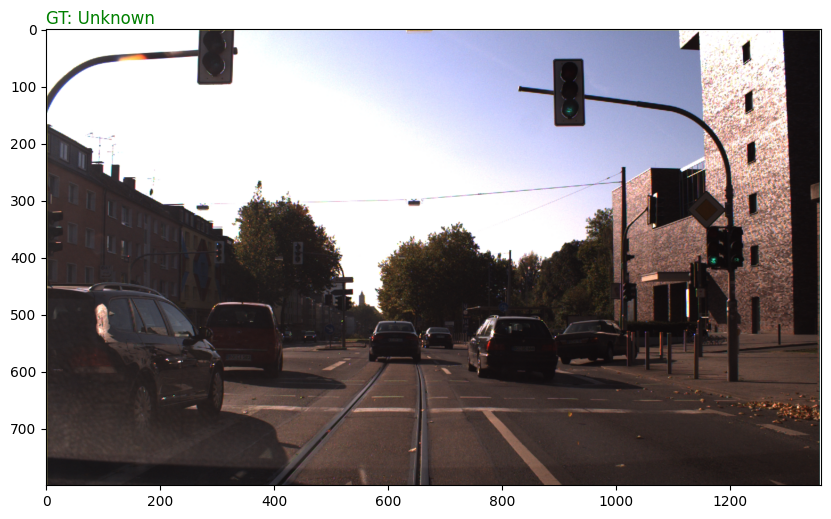

In [14]:
def visualize_prediction(dataset, model, device, idx=50, score_threshold=0.5):
    model.eval()
    image, target = dataset[idx]
    image_input = image.to(device).unsqueeze(0)

    with torch.no_grad():
        output = model(image_input)[0]

    fig, ax = plt.subplots(1, figsize=(10, 8))
    image_np = image.permute(1, 2, 0).cpu().numpy()
    ax.imshow(image_np)

    # Ground truth
    gt_box = target['boxes'][0]
    gt_label = target['labels'][0].item()
    ax.add_patch(patches.Rectangle((gt_box[0], gt_box[1]),
                                   gt_box[2]-gt_box[0],
                                   gt_box[3]-gt_box[1],
                                   linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth'))
    ax.text(gt_box[0], gt_box[1]-10, f"GT: {dataset.get_class_name(gt_label)}", color='green', fontsize=12)

    # Predictions
    for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
        if score >= score_threshold:
            x1, y1, x2, y2 = box
            class_name = dataset.get_class_name(label.item())
            ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                           linewidth=2, edgecolor='r', facecolor='none'))
            ax.text(x1, y1 - 10, f"{class_name} ({score:.2f})", color='red', fontsize=12)

    plt.axis('off')
    plt.title("Prediction vs Ground Truth")
    plt.show()

visualize_prediction(test_dataset, model, device, idx=50)
